In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from seaborn import kdeplot

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

## Leapfrog

In [2]:
def leapfrog(A, x0, v0, stepsize=1, n_steps=10):
    '''
    Solves ODE of the form (d^2 x)/(d t^2) = A(x)
    using leapfrog iterations (https://en.wikipedia.org/wiki/Leapfrog_integration, kick-drift-kick' form)

    Parameters:
    
    A : function
        Acceleration function R^p -> R^p. Takes position vector x and 
        returns acceleration: a = A(x).
    x0 : array
        Initial condition for position.
    v0 : array 
        Initial condition for velocity.
    stepsize : number
        Stepsize, default = 1.
    n_steps : int
        Number of steps, default = 10.
    '''
    dt = stepsize ## alias
    a0 = A(x0)
    v = v0 - a0 * dt/2 ## backward 1/2 step
    x = x0
    for i in range(n_steps):
        a = A(x)
        v = v + a * dt
        x = x + v * dt
        yield x, v + a * dt/2



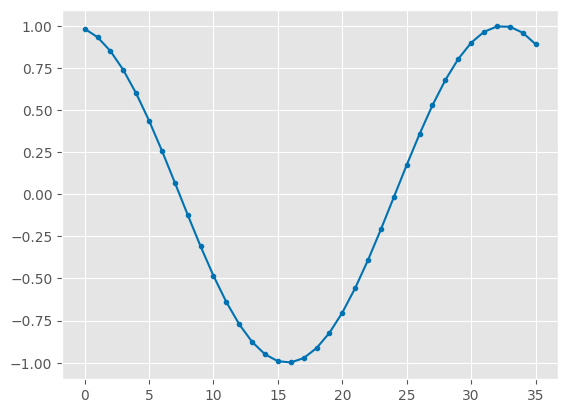

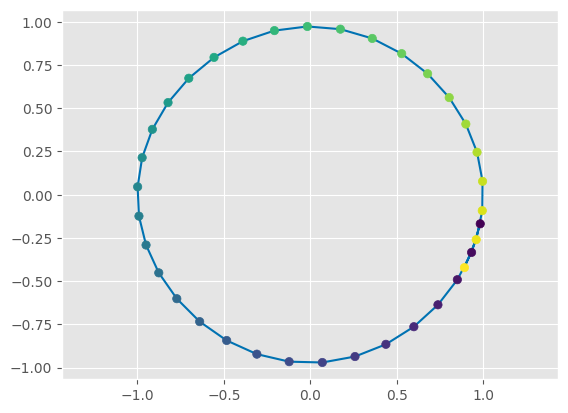

In [3]:
A = lambda x:-np.sin(x)
x0, v0 = 1, 0.0

states = leapfrog(A, x0, v0, stepsize=0.2, n_steps=36)

## Option 1: take the entire trajectory
states = np.array(list(states))
## Option 2: take only the final solution
*_, final = states


plt.plot(states[:,0], '.-')
plt.show()
plt.plot(states[:,0], states[:,1], '-')
plt.scatter(states[:,0], states[:,1], c=np.arange(states.shape[0]), zorder=2)
plt.axis('equal')
plt.show()

## Hamiltonian Monte Carlo (HMC)

In [4]:
def HMC(U, theta0, std=1, stepsize=0.01, n_steps=10, n_samples=10):
    '''
    Hamiltonian Monte Carlo
    
    Parameters:
    
    U : function
        Potential energy function U(theta:Tensor) -> phi:Tensor. 
        Differentiable w.r.t theta, through U(theta).backward()
    theta0 : PyTorch tensor
        Initial condition
    std : number
        sqrt(mass), used as std of Gaussian
    stepsize : number
    n_steps : number
    n_samples : number
    '''
    
    def neg_dU(theta):
        '''negative gradient of dU through autodiff'''
        theta = theta.detach().requires_grad_(True)
        if theta.grad is not None:
            theta.grad.fill_(0)
        u = U(theta)
        u.backward()
        return -theta.grad
    def H(theta, r):
        '''Hamiltonian function'''
        return U(theta) + 1/2 * (r**2).sum()

    ## TODO: multivariable version
#     def neg_dU(*args):
#         '''negative gradient of dU through autodiff'''
#         args = [arg.detach().requires_grad_(True) for arg in args]
#         for arg in args:
#             if arg.grad is not None:
#                 arg.grad.fill_(0)
#         u = U(*args)
#         u.backward()
#         return [-arg.grad for arg in args]
    
#     def H(args, r):
#         '''Hamiltonian function'''
#         return U(*args) + 1/2 * (r**2).sum()
        
    theta = theta0
    for t in range(n_samples):
        rt = torch.randn(theta.shape[0]) * std
        
        states = leapfrog(neg_dU, theta, rt, stepsize, n_steps)
        states = list(states)
        *_, proposal = states
        
        
        ## Metropolis-Hastings correction
        u = torch.rand(1)
        p = torch.exp(
            H(theta, rt)
            - H(proposal[0], proposal[1]) 
        )
        if u < min(1, p):
            ## accept
            theta = proposal[0]
            sample = proposal[0]
            auxiliary = proposal[1]
        else:
            ## reject
            sample = theta
            auxiliary = rt
            
        yield dict(
            acceptance = p,
            sample = sample,
            auxiliary = auxiliary,
            sample_states = [s[0] for s in states],
            auxiliary_states = [s[1] for s in states],
        )

## 1D plots

### 0. Prepare 1D data

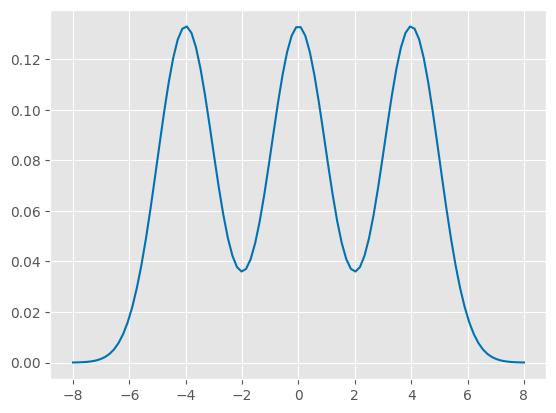

CPU times: user 14.2 s, sys: 110 ms, total: 14.3 s
Wall time: 14.1 s


In [5]:
%%time

# ## 1D
U = lambda x: -torch.log(
    1 / np.sqrt(2*np.pi) * (
        1/3 * torch.exp(-x**2 / 2) 
        + 1/3 * torch.exp(-(x+4)**2 / 2) + 
        + 1/3 * torch.exp(-(x-4)**2 / 2)
    ) 
)
xmin, xmax = -8,8
x = torch.linspace(xmin, xmax, 100)
y = torch.exp(-U(x))
plt.plot(x,y)
plt.show()

init = torch.randn(1)
n_burnin = 50
n_samples = 400
results = HMC(
    U, init, 
    std=1, stepsize=0.1, 
    n_steps=100, 
    n_samples = n_burnin + n_samples)

results = list(results)
samples = torch.stack([r['sample'] for r in results[n_burnin:]]).squeeze()
states = torch.stack([torch.stack(r['sample_states']) for r in results[n_burnin:]]).squeeze()
auxiliary_states = torch.stack([torch.stack(r['auxiliary_states']) for r in results[n_burnin:]]).squeeze()


### 1. Hamiltonian paths

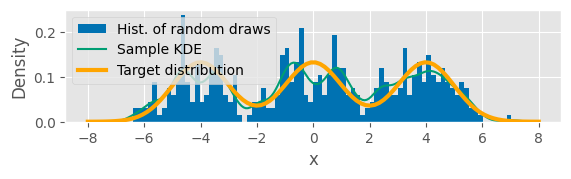

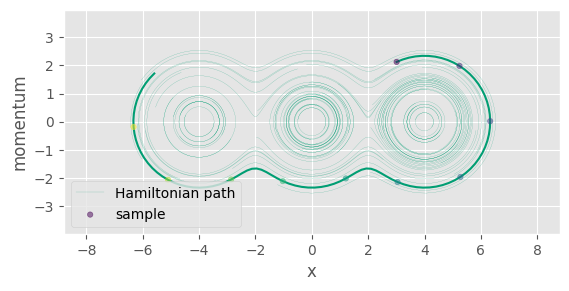

In [6]:
gs = GridSpec(2,1, height_ratios=[4,2])


## Draw target probability, whose neg log is defined as potential energy
ax = plt.subplot(gs[1])
plt.hist(samples.numpy(), bins=80, density=True, label='Hist. of random draws')
kdeplot(samples.numpy(), linestyle='-', bw_adjust=0.3, label='Sample KDE')
plt.plot(x, y, color='orange', linestyle='-', zorder=3, lw=3, label='Target distribution')
plt.legend()
plt.xlabel('x')
plt.show()


## Draw state trajectories, whose final states are sample proposals
plt.subplot(gs[0], sharex=ax)
n_sample_plot = min(50, states.shape[0])
for i in range(n_sample_plot):
    ## draw one curve with legend, draw the rest without
    if i == 0:
        plt.plot(states[i,:], auxiliary_states[i,:], 'C1-', lw=0.1, label='Hamiltonian path')
    else:
        plt.plot(states[i,:], auxiliary_states[i,:], 'C1-', lw=0.1,)  
        
        
## Draw samples
sample_index = min(11, states.shape[0]-1)
pos, momentum = states[sample_index,::10], auxiliary_states[sample_index, ::10]
plt.plot(states[sample_index,:], auxiliary_states[sample_index,:], 'C1-')  
plt.scatter(
    pos,
    momentum,
    c=np.arange(pos.shape[0]),
    zorder=2, s=15, alpha=0.5, 
    label='sample'
)
plt.legend()
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('momentum')




plt.show()

## WIP: multi variable HMC


In [ ]:
%%time

# ## 1D
# U = lambda x: -torch.log(
#     1 / np.sqrt(2*np.pi) * (
#         1/3 * torch.exp(-x**2 / 2) 
#         + 1/3 * torch.exp(-(x+4)**2 / 2) + 
#         + 1/3 * torch.exp(-(x-4)**2 / 2)
#     ) 
# )
# init = torch.randn(1)

## 2D
mu = torch.tensor([0.1, 0])
sigma = torch.tensor([
    [2.0, 1],
    [1,   1]
])
sigma_inv = torch.inverse(sigma)
def U(x): 
    cx = x-mu
    return -torch.log(
        torch.exp(- ((cx @ sigma_inv) * cx).sum(dim=1) / 2) 
    )
init = torch.randn(1,2)

n_burnin = 0
n_samples = 150
n_steps = 100
results = HMC(U, init, std=1, stepsize=0.1, n_steps=n_steps, n_samples = n_burnin + n_samples)

results = list(results)
samples = torch.stack([r['sample'] for r in results[n_burnin:]]).squeeze()
states = torch.stack([torch.stack(r['sample_states']) for r in results[n_burnin:]]).squeeze()

In [ ]:
plt.hist2d(samples[:,0].numpy(), samples[:,1].numpy(), bins=50)
plt.axis('equal')
plt.show()

## Monitoring potential energy

In [ ]:
potential = U(states[:6].view(-1, states.shape[-1]))
plt.figure(figsize=[12,3])
plt.plot(potential, '.')
plt.ylabel('Energy level')
plt.xticks(np.arange(0,plt.xlim()[1],n_steps)-1)

plt.show()

## Plot acceptance rate

In [ ]:
acceptance_rate = torch.tensor([r['acceptance'] for r in results])
acceptance_rate[acceptance_rate>1] = 1
plt.hist(acceptance_rate.numpy(), bins=np.linspace(0,1,20))
plt.xlim([0,1]);

In [ ]:
# plt.plot(samples[:,0],samples[:,1], '.-')
# plt.scatter(samples[:,0],samples[:,1])
# plt.hist(samples[:,0].numpy(), bins=30);
